# Imports

In [20]:
import pandas as pd
import os
from sqlalchemy import create_engine, text
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Setup
sns.set_theme(style="whitegrid")

# Extração do PostgreSQL

In [ ]:
# --- CONFIGURAÇÃO DE CONEXÃO COM POSTGRESQL ---
# As variáveis são lidas do ambiente Docker injetado pelo docker-compose
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_DB = os.environ.get("POSTGRES_DB")
DB_HOST = os.environ.get("DB_HOST") 
RAW_TABLE_NAME = "heart_disease_raw" # A tabela que o FastAPI carrega

DATABASE_URL = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{DB_HOST}:5432/{POSTGRES_DB}"
engine = create_engine(DATABASE_URL)

# --- AÇÃO CHAVE: LER A TABELA PERSISTIDA PARA O DATAFRAME 'df' ---
try:
    # Lendo o DataFrame diretamente da tabela que contém os dados brutos
    df = pd.read_sql(text(f"SELECT * FROM {RAW_TABLE_NAME}"), engine)
    
    print(f"VERIFICAÇÃO: DataFrame 'df' lido com sucesso da tabela PostgreSQL: {RAW_TABLE_NAME}")
    print(f"Total de linhas para limpeza: {len(df)}")

except Exception as e:
    print("\n" + "="*50)
    print("ERRO CRÍTICO AO LER DO POSTGRESQL!")
    print("O FastAPI /load_raw_to_db/ falhou ou o pg_db não está pronto.")
    print(f"Erro: {e}")
    print("="*50)
    exit()

VERIFICAÇÃO: DataFrame 'df' lido com sucesso da tabela PostgreSQL: heart_disease_raw
Total de linhas para limpeza: 1190

ANÁLISE ESTATÍSTICA (ENTENDIMENTO DOS DADOS)
               age          sex  chest pain type  resting bp s  cholesterol  \
count  1190.000000  1190.000000      1190.000000   1190.000000  1190.000000   
mean     53.720168     0.763866         3.232773    132.153782   210.363866   
std       9.358203     0.424884         0.935480     18.368823   101.420489   
min      28.000000     0.000000         1.000000      0.000000     0.000000   
25%      47.000000     1.000000         3.000000    120.000000   188.000000   
50%      54.000000     1.000000         4.000000    130.000000   229.000000   
75%      60.000000     1.000000         4.000000    140.000000   269.750000   
max      77.000000     1.000000         4.000000    200.000000   603.000000   

       fasting blood sugar  resting ecg  max heart rate  exercise angina  \
count          1190.000000  1190.000000     11

# Análise Exploratória de Dados

### Informações Básicas

In [4]:
print("\n--- Primeiras 5 Linhas: ---")
df.head()


--- Primeiras 5 Linhas: ---


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [5]:
print("\n--- Informações do DataFrame: ---")
df.info()


--- Informações do DataFrame: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [6]:
print(f"\nO DataFrame tem {df.shape[0]} linhas e {df.shape[1]} colunas.")


O DataFrame tem 1190 linhas e 12 colunas.


In [8]:
print("\n--- Resumo Estatístico: ---")
df.describe()


--- Resumo Estatístico: ---


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,3.232773,132.153782,210.363866,0.213445,0.698319,139.732773,0.387395,0.922773,1.624370,0.528571
std,9.358203,0.424884,0.935480,18.368823,101.420489,0.409912,0.870359,25.517636,0.487360,1.086337,0.610459,0.499393
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,188.000000,0.000000,0.000000,121.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,229.000000,0.000000,0.000000,140.500000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,269.750000,0.000000,2.000000,160.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


### Avaliação dos Valores Nulos

In [9]:
print("\n--- Avaliação dos Valores Nulos: ---")
df.isnull().sum()


--- Avaliação dos Valores Nulos: ---


age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

### Avaliação de Duplicatas

In [10]:
print("\n--- Avaliação dos Registros Duplicados: ---")
n_duplicates = df.duplicated().sum()
print(f"\nTotal de linhas duplicadas: {n_duplicates}")


--- Avaliação dos Registros Duplicados: ---

Total de linhas duplicadas: 272


No artigo, não forma identificados registros duplicados. Porém, nesse dataset foram identificadas 272 duplicatas. Dessa forma, foi necessária a remoção para evitar overfitting durante o processo de modelagem. 

### Avaliação dos Outliers

In [11]:
print("\n--- Avaliação dos Outliers: ---")
numeric_features = df.select_dtypes(include=[np.number]).columns.drop('target')
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

outlier_summary = {}
for col in numeric_features:
    n_outliers = detect_outliers_iqr(df, col)
    if n_outliers > 0:
        outlier_summary[col] = n_outliers

if outlier_summary:
    print("Outliers detectados por feature:")
    for col, count in outlier_summary.items():
        print(f"  - {col}: {count} outliers")
else:
    print("Nenhum outlier extremo detectado")


--- Avaliação dos Outliers: ---
Outliers detectados por feature:
  - sex: 281 outliers
  - chest pain type: 66 outliers
  - resting bp s: 37 outliers
  - cholesterol: 193 outliers
  - fasting blood sugar: 254 outliers
  - max heart rate: 1 outliers
  - oldpeak: 11 outliers


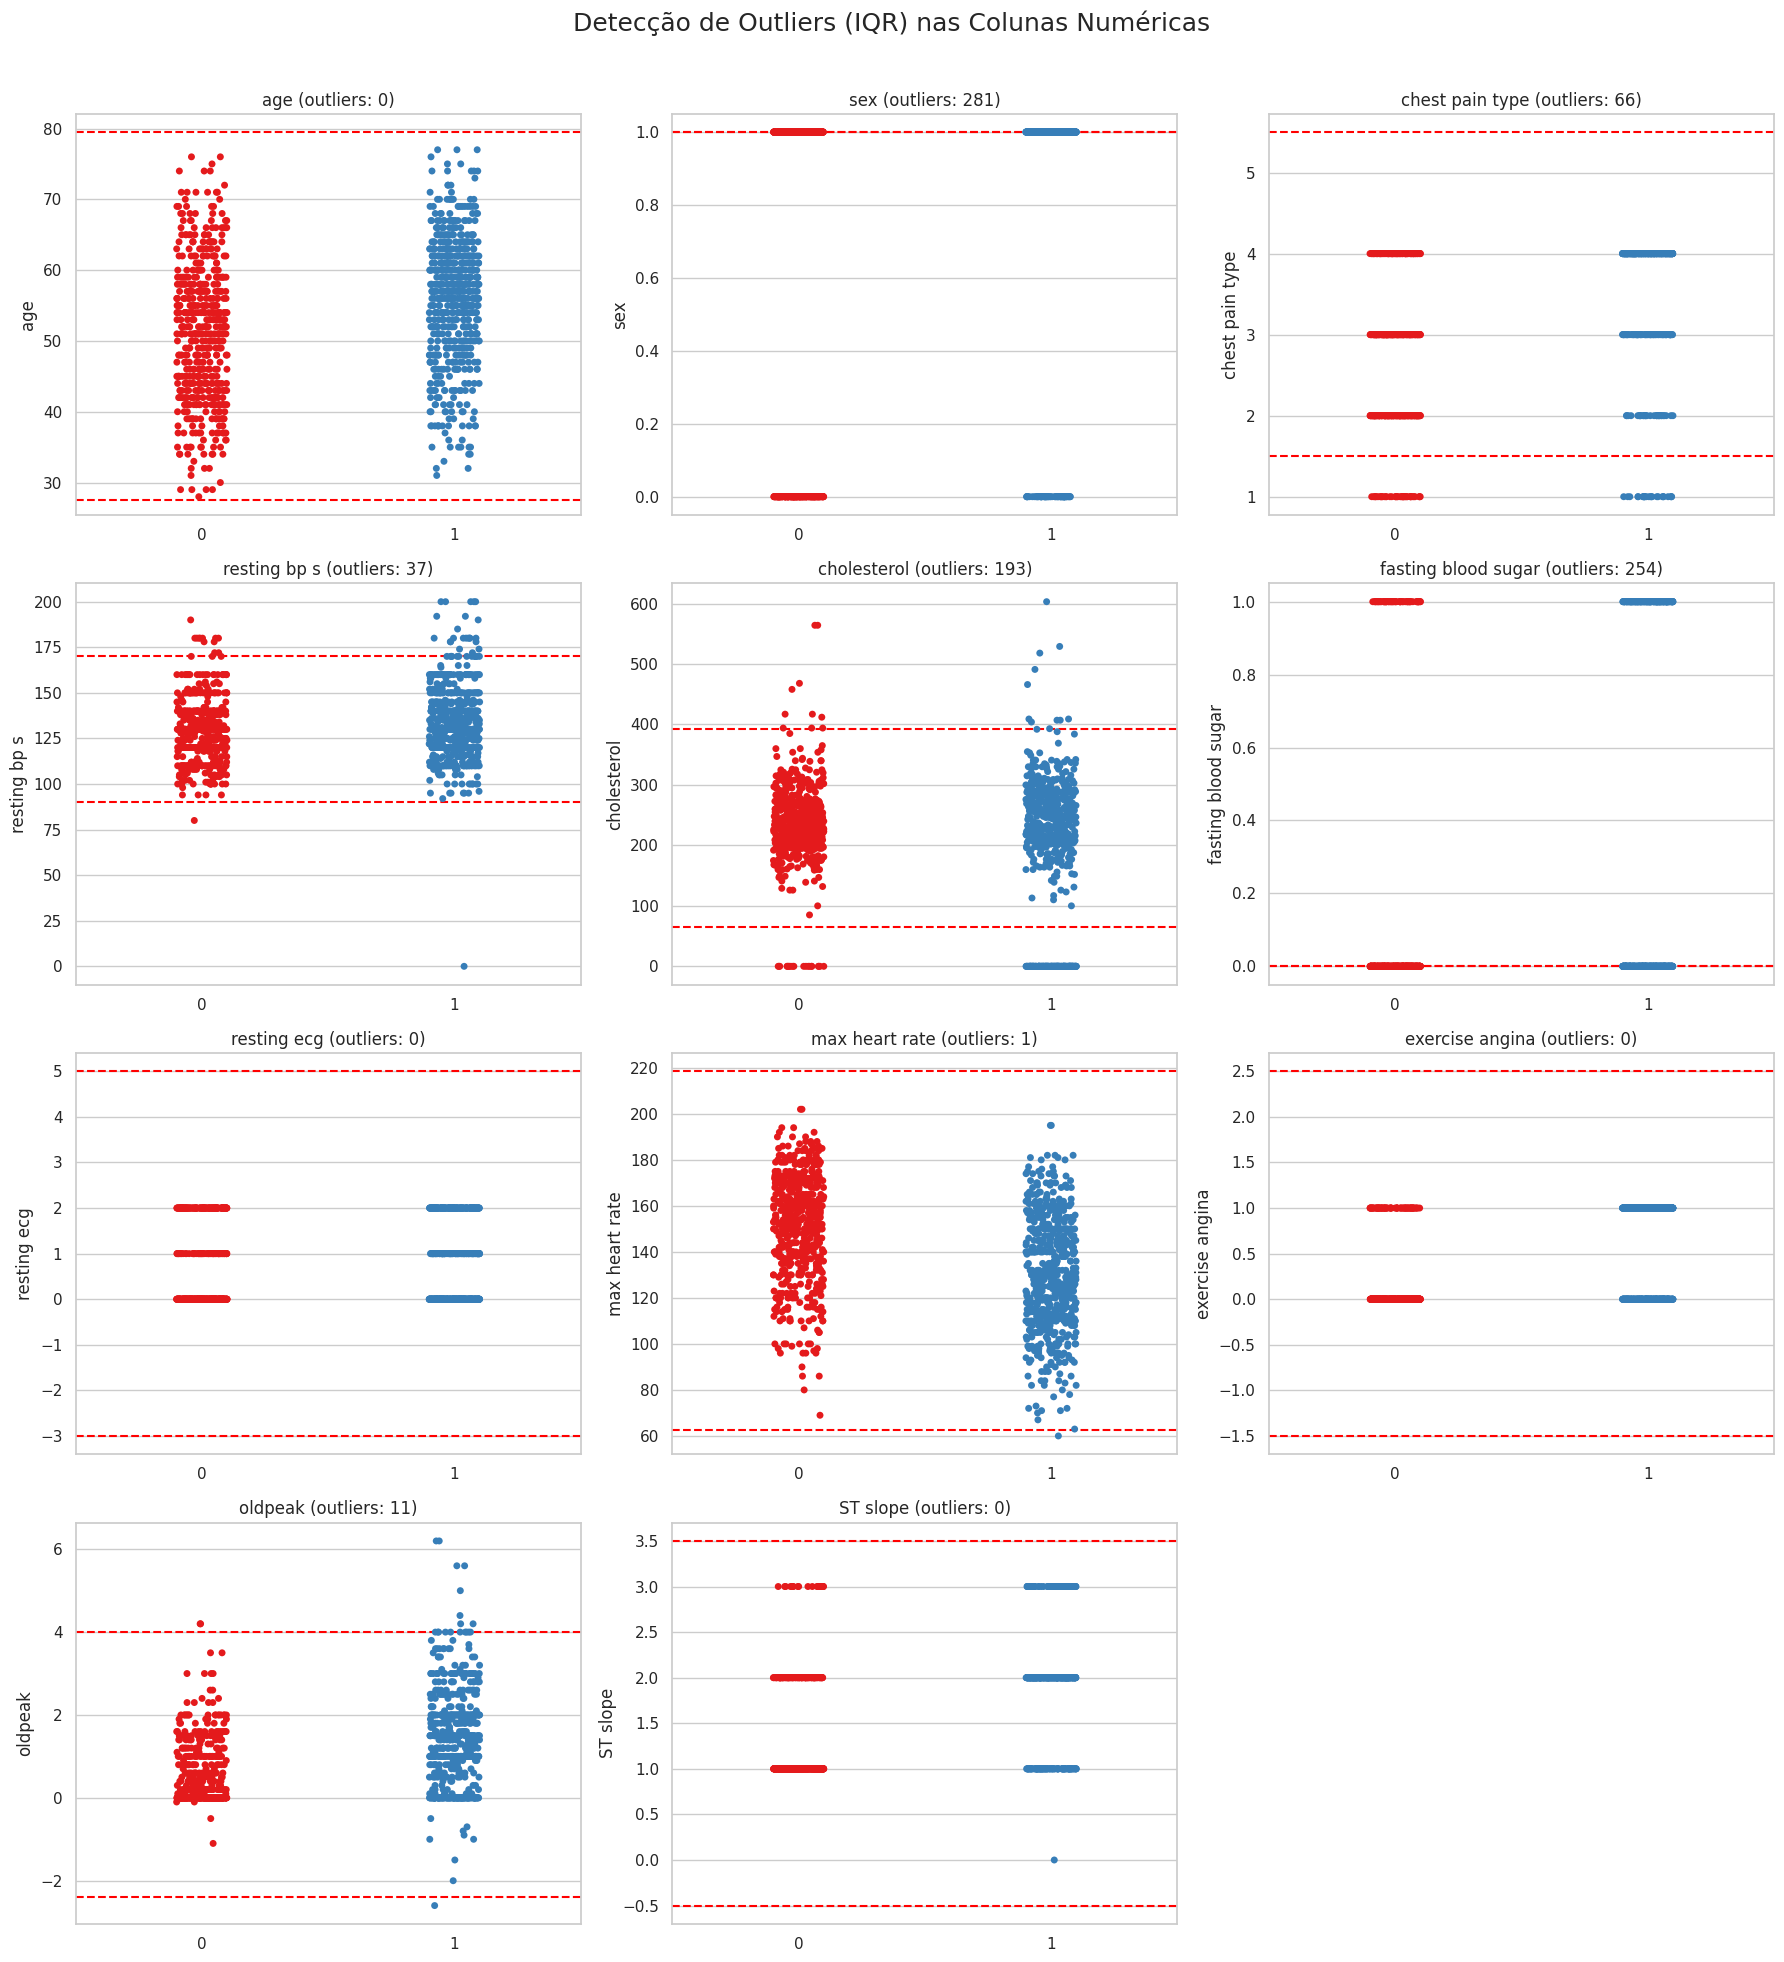

In [12]:
TARGET_COLUMN = 'target'

# Pega automaticamente todas as colunas numéricas
numeric_cols = df.select_dtypes(include='number').columns.tolist()

numeric_cols = [c for c in numeric_cols if c != TARGET_COLUMN]

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return lower, upper, outliers

# ----------- SUBPLOTS AUTOMÁTICOS -----------
n_cols = 3 
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

plt.figure(figsize=(n_cols * 6, n_rows * 5))
plt.suptitle("Detecção de Outliers (IQR) nas Colunas Numéricas", fontsize=18)

for i, col in enumerate(numeric_cols, 1):
    lower, upper, outliers_df = detect_outliers_iqr(df, col)

    plt.subplot(n_rows, n_cols, i)
    
    sns.stripplot(
        x=TARGET_COLUMN, 
        y=col, 
        data=df, 
        hue=TARGET_COLUMN, 
        palette="Set1", 
        jitter=True,
        legend=False
    )
    
    # Linhas de limite IQR
    plt.axhline(upper, color="red", linestyle="--")
    plt.axhline(lower, color="red", linestyle="--")

    plt.title(f"{col} (outliers: {len(outliers_df)})")
    plt.xlabel("")
    plt.ylabel(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Avaliação de Valores Impossíveis

In [15]:
def detectar_valores_impossiveis(df):

    # Ranges fisiológicos baseados em guidelines médicas (AHA, NIH, ACC)
    ranges = {
        "age": (18, 100),
        "resting bp s": (60, 260),
        "cholesterol": (70, 900),
        "max heart rate": (30, 260),
        "oldpeak": (-3.0, 7.0)
    }

    resultados = {}

    for col, (lo, hi) in ranges.items():
        impossiveis = df[(df[col] < lo) | (df[col] > hi)]
        resultados[col] = {
            "total_impossiveis": len(impossiveis),
            "percentual": len(impossiveis) / len(df) * 100,
            "indices": impossiveis.index.tolist(),
            "valores": impossiveis[col].tolist()
        }

    return resultados

resultados = detectar_valores_impossiveis(df)

for col, info in resultados.items():
    print(f"\n==== {col} ====")
    print(f"Total impossíveis: {info['total_impossiveis']} ({info['percentual']:.2f}%)")
    print(f"Exemplos: {info['valores'][:10]}")


==== age ====
Total impossíveis: 0 (0.00%)
Exemplos: []

==== resting bp s ====
Total impossíveis: 1 (0.08%)
Exemplos: [0]

==== cholesterol ====
Total impossíveis: 172 (14.45%)
Exemplos: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

==== max heart rate ====
Total impossíveis: 0 (0.00%)
Exemplos: []

==== oldpeak ====
Total impossíveis: 0 (0.00%)
Exemplos: []


1. Idade (age): Range fisiológico: 0–120 anos. Mas para estudos epidemiológicos cardiovasculares (Framingham, Cleveland Clinic), populações relevantes ficam entre 18 e 100 anos. 

2. Pressão arterial sistólica (resting bp s): Valores possíveis em humanos (AHA – American Heart Association): 
- Normal: 90–120 mmHg
- Elevada: 120–129 mmHg
- Hipertensão estágio 1: 130–139 mmHg
- Estágio 2: 140–180 mmHg
- Crise hipertensiva: >180 mmHg (raramente >220)
- Valores impossíveis: <60 ou >260
0 mmHg é fisiologicamente impossível (indica erro, missing ou defeito). Referência: AHA, 2024 — "Understanding Blood Pressure Readings".

3. Colesterol total (cholesterol): Valores normais (NIH, 2023): 
- Desejável: <200 mg/dL
- Limítrofe: 200–239 mg/dL
- Alto: ≥240 mg/dL
- Valores fisiologicamente possíveis: 70–500 mg/dL
- Valores impossíveis: 0 mg/dL e >900 mg/dL (quase inexistente; o maior caso documentado é ~1300 mg/dL em hipercolesterolemia extrema, mas é raríssimo). Referência: NIH "High Blood Cholesterol" Guidelines.

4. Frequência cardíaca máxima (max heart rate): Segundo American College of Cardiology (ACC), frequência máxima típica estimada: FCmáx ≈ 220 – idade. Para humanos saudáveis:
- Mínimo fisiológico em repouso: 35–40
- Máximo durante esforço: 180–210
- Valores impossíveis: <30 bpm (quase incompatível com vida em ambiente não hospitalar) e 240 bpm (excepcionalmente raro)

5. Oldpeak — Depressão do ST: Valores normais clínicos típicos:
- Normal: 0 a 1 mm
- Isquemia leve: 1–2 mm
- Isquemia grave: >2 mm
Em ECG: 
- Range fisiológico: –2.0 a +5.0 mm
- Valores impossíveis: < –3.0 mm (negativação maior que 3 mm é muito rara na prática) e +7.0 mm (quase nunca ocorre)

# Pré-processamento

## Limpeza dos Dados

### Remoção dos Valores Duplicados

In [16]:
# ===== 1. Remoção das duplicatas =====
df_sem_duplicatas = df.drop_duplicates().reset_index(drop=True)

print("Linhas antes:", len(df))
print("Linhas depois da remoção de duplicatas:", len(df_sem_duplicatas))

Linhas antes: 1190
Linhas depois da remoção de duplicatas: 918


### Substituição dos Valores Impossíveis pela Mediana

In [17]:
# ===== 2. Substituição dos valores impossíveis =====
# Valores impossíveis identificados:
# resting bp s: 0
# cholesterol: 0

df_clean = df_sem_duplicatas.copy()

# Substituir resting bp s = 0 pela mediana (ignorando os zeros)
rbp_median = df_clean.loc[df_clean["resting bp s"] > 0, "resting bp s"].median()
df_clean.loc[df_clean["resting bp s"] == 0, "resting bp s"] = rbp_median

# Substituir cholesterol = 0 pela mediana
chol_median = df_clean.loc[df_clean["cholesterol"] > 0, "cholesterol"].median()
df_clean.loc[df_clean["cholesterol"] == 0, "cholesterol"] = chol_median

In [18]:
print("\n--- Primeiras linhas após pré-processamento ---")
display(df_clean.head())

print("\n--- Informações do DF após pré-processamento ---")
display(df_clean.info())

print("\n--- Estatísticas após pré-processamento ---")
display(df_clean.describe())


--- Primeiras linhas após pré-processamento ---


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0



--- Informações do DF após pré-processamento ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  918 non-null    int64  
 1   sex                  918 non-null    int64  
 2   chest pain type      918 non-null    int64  
 3   resting bp s         918 non-null    int64  
 4   cholesterol          918 non-null    int64  
 5   fasting blood sugar  918 non-null    int64  
 6   resting ecg          918 non-null    int64  
 7   max heart rate       918 non-null    int64  
 8   exercise angina      918 non-null    int64  
 9   oldpeak              918 non-null    float64
 10  ST slope             918 non-null    int64  
 11  target               918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


None


--- Estatísticas após pré-processamento ---


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,3.251634,132.538126,243.204793,0.233115,0.603486,136.809368,0.404139,0.887364,1.636166,0.553377
std,9.432617,0.407701,0.931031,17.990127,53.401297,0.423046,0.805968,25.460334,0.490992,1.066570,0.609341,0.497414
min,28.000000,0.000000,1.000000,80.000000,85.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,214.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,237.000000,0.000000,0.000000,138.000000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [19]:
# ===== 4. Distribuição das classes do target =====
print("\n--- Distribuição das classes do target ---")
target_counts = df_clean["target"].value_counts()
target_percent = df_clean["target"].value_counts(normalize=True) * 100

print(pd.DataFrame({
    "Contagem": target_counts,
    "Percentual (%)": target_percent.round(2)
}))


--- Distribuição das classes do target ---
        Contagem  Percentual (%)
target                          
1            508           55.34
0            410           44.66


## Codificação dos Dados

In [30]:
# Colunas categóricas a converter
categorical_cols = ["chest pain type", "resting ecg", "ST slope"]

# OneHotEncoder com drop='first' evita multicolinearidade
ohe = OneHotEncoder(drop=None, sparse_output=False)

# Ajustar e transformar
encoded = ohe.fit_transform(df_clean[categorical_cols])

# Novo dataframe codificado
encoded_df = pd.DataFrame(encoded, 
                          columns=ohe.get_feature_names_out(categorical_cols))

# Remover colunas originais e substituir pelas novas
df_encoded = pd.concat([df_clean.drop(columns=categorical_cols).reset_index(drop=True),
                        encoded_df.reset_index(drop=True)], axis=1)

# Visualizar resultado
display(df_encoded.head())
print("Shape final:", df_encoded.shape)

,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,target,chest pain type_1,chest pain type_2,chest pain type_3,chest pain type_4,resting ecg_0,resting ecg_1,resting ecg_2,ST slope_0,ST slope_1,ST slope_2,ST slope_3
0,40,1,140,289,0,172,0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,49,0,160,180,0,156,0,1.0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,1,130,283,0,98,0,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,48,0,138,214,0,108,1,1.5,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,54,1,150,195,0,122,0,0.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Shape final: (918, 20)


A escolha pelo uso do One-Hot Encoding para as variáveis chest pain type, resting ecg e ST slope foi feita porque essas variáveis representam categorias sem ordem natural (variáveis nominais).
Embora o dataset original já viesse numericamente codificado, esses números não representam hierarquia — por exemplo, o tipo de dor no peito categorizado como “4” não é maior ou mais importante que o tipo “1”.

Se mantivéssemos a codificação numérica original, modelos sensíveis à escala ou que assumem relações ordinais poderiam interpretar incorretamente essas variáveis, introduzindo viés indesejado.
Por isso, convertê-las com One-Hot Encoding garante que:

- cada categoria se torna uma coluna binária independente;

- não há inferência de ordem entre categorias;

- elimina-se a possibilidade de viés numérico artificial;

- melhora o desempenho de diversos modelos lineares e baseados em distância.

Essa codificação é especialmente adequada quando planejamos utilizar modelos como Logistic Regression, SVM e KNN, que são altamente sensíveis à escala e ao significado geométrico dos atributos.

### Dimensionamento dos Dados

In [31]:
# Separar numericas e categoricas
num_cols = ["age", "resting bp s", "cholesterol",
            "fasting blood sugar", "max heart rate", "oldpeak"]

# Copiar dataset para não sujar o original
df_scaled = df_encoded.copy()

# Aplicar o scaler
scaler = StandardScaler()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

df_scaled.head()

,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,target,chest pain type_1,chest pain type_2,chest pain type_3,chest pain type_4,resting ecg_0,resting ecg_1,resting ecg_2,ST slope_0,ST slope_1,ST slope_2,ST slope_3
0,-1.433140,1,0.415002,0.858035,-0.551341,1.382928,0,-0.832432,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.478484,0,1.527329,-1.184227,-0.551341,0.754157,0,0.105664,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.751359,1,-0.141161,0.745617,-0.551341,-1.525138,0,-0.832432,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.584556,0,0.303769,-0.547191,-0.551341,-1.132156,1,0.574711,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.051881,1,0.971166,-0.903182,-0.551341,-0.581981,0,-0.832432,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Visualizações

In [38]:
df_final = df_scaled.copy()

## Histogramas

In [40]:
# identificando colunas numéricas (excluindo dummies)
numerical_cols = ["age", "resting bp s", "cholesterol", 
                  "fasting blood sugar", "max heart rate", "oldpeak"]

# colunas binárias simples (0/1)
binary_cols = ["sex", "exercise angina", "target"]

# grupos de one-hot (para visualizar juntas)
onehot_groups = {
    "chest pain type": ["chest pain type_1","chest pain type_2", "chest pain type_3", "chest pain type_4"],
    "resting ecg": ["resting ecg_0", "resting ecg_1", "resting ecg_2"],
    "ST slope": ["ST slope_1", "ST slope_1", "ST slope_2", "ST slope_3"]
}

### Numéricas

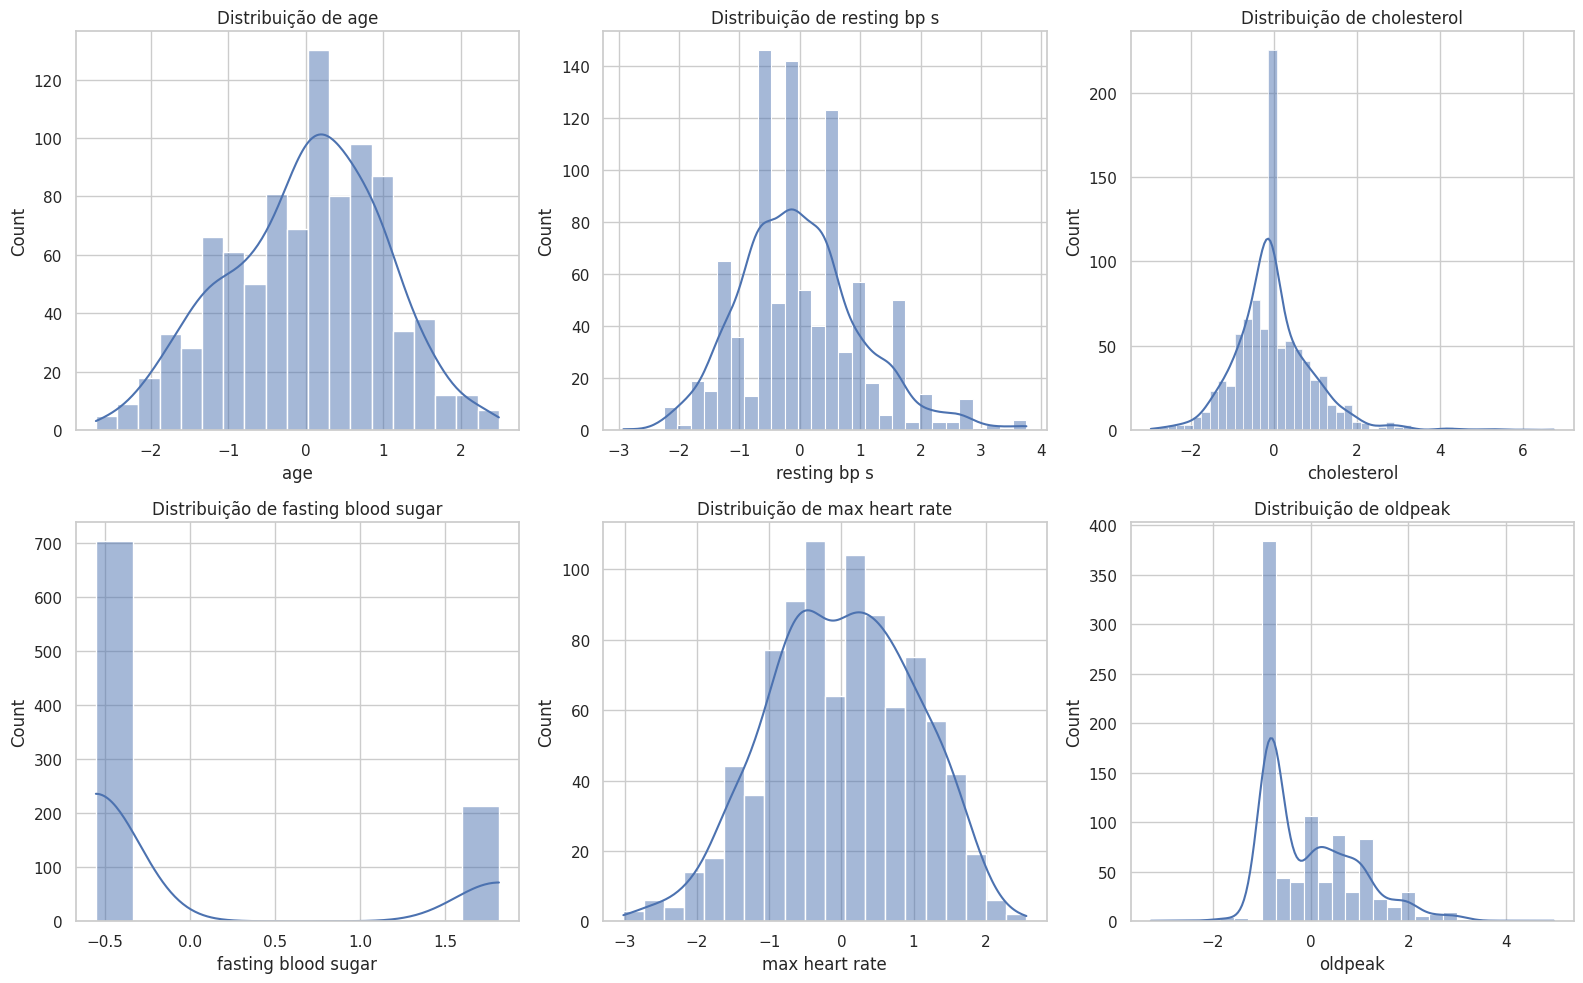

In [34]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_final[col], kde=True)
    plt.title(f"Distribuição de {col}")
plt.tight_layout()
plt.show()

### Categóricas Binárias

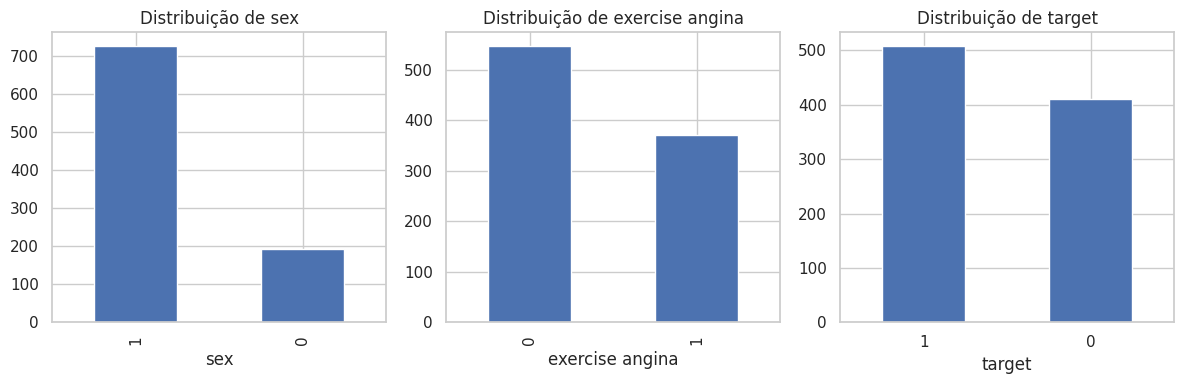

In [35]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(binary_cols, 1):
    plt.subplot(1, 3, i)
    df_final[col].value_counts().plot(kind='bar')
    plt.title(f"Distribuição de {col}")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Categóricas One-hot Agrupadas

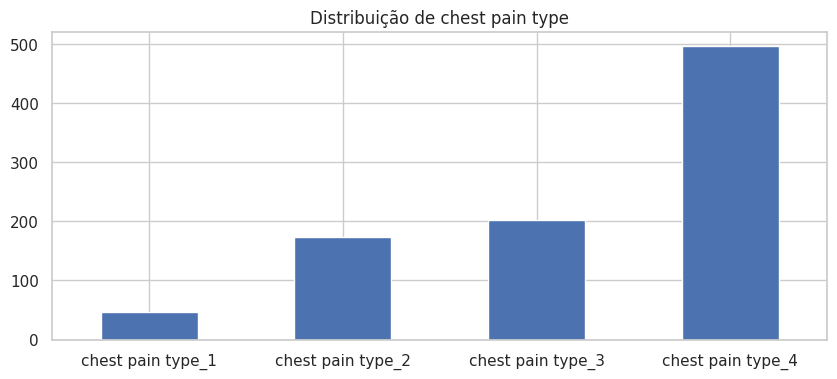

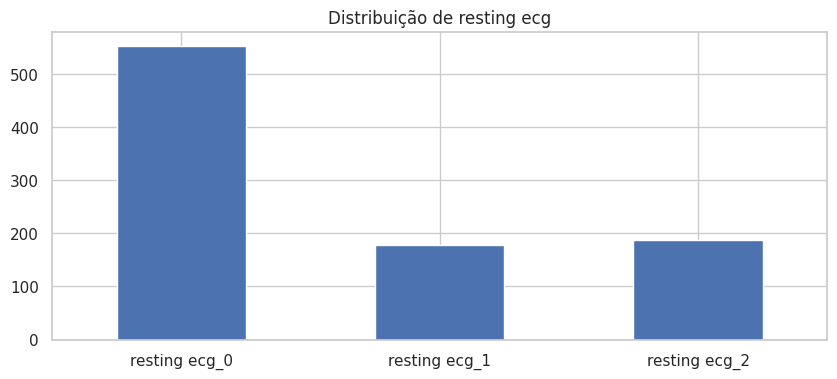

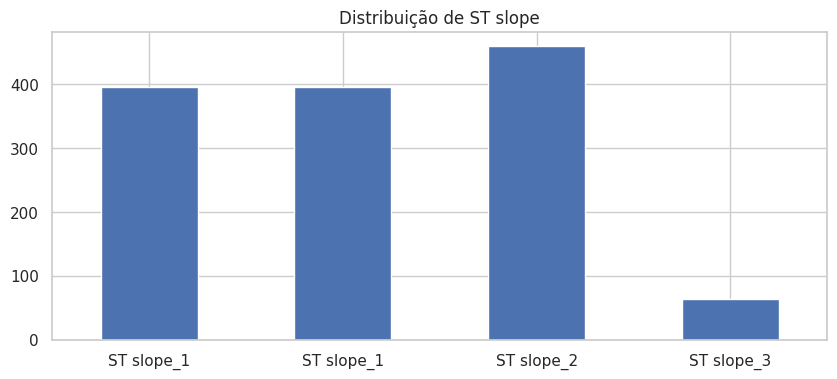

In [43]:
for group_name, cols in onehot_groups.items():
    plt.figure(figsize=(10, 4))
    counts = df_final[cols].sum().sort_index()
    counts.plot(kind="bar")
    plt.title(f"Distribuição de {group_name}")
    plt.xticks(rotation=0)
    plt.show()

## Matriz de Correlação

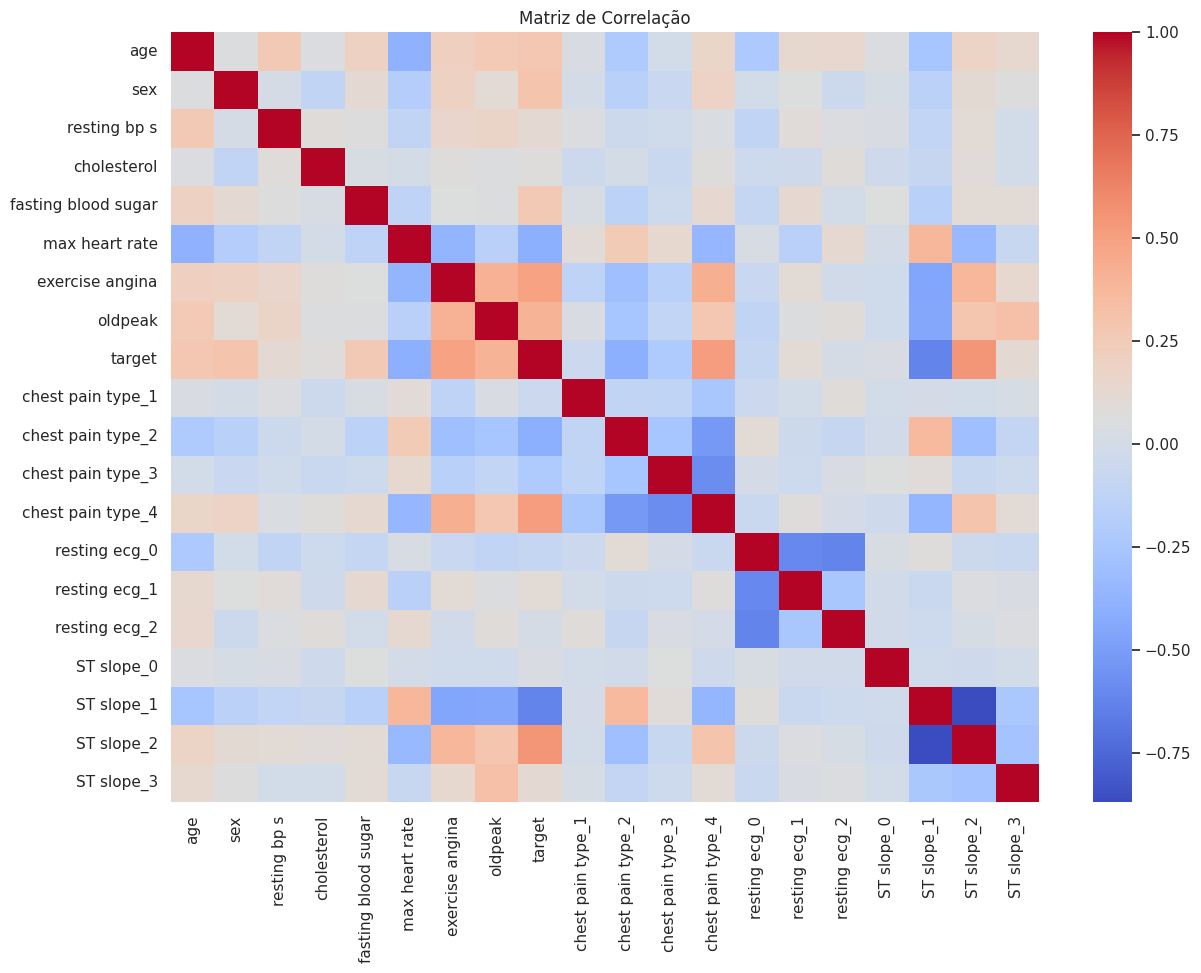

In [45]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_final.corr(), cmap="coolwarm", annot=False)
plt.title("Matriz de Correlação")
plt.show()

### Só as numéricas

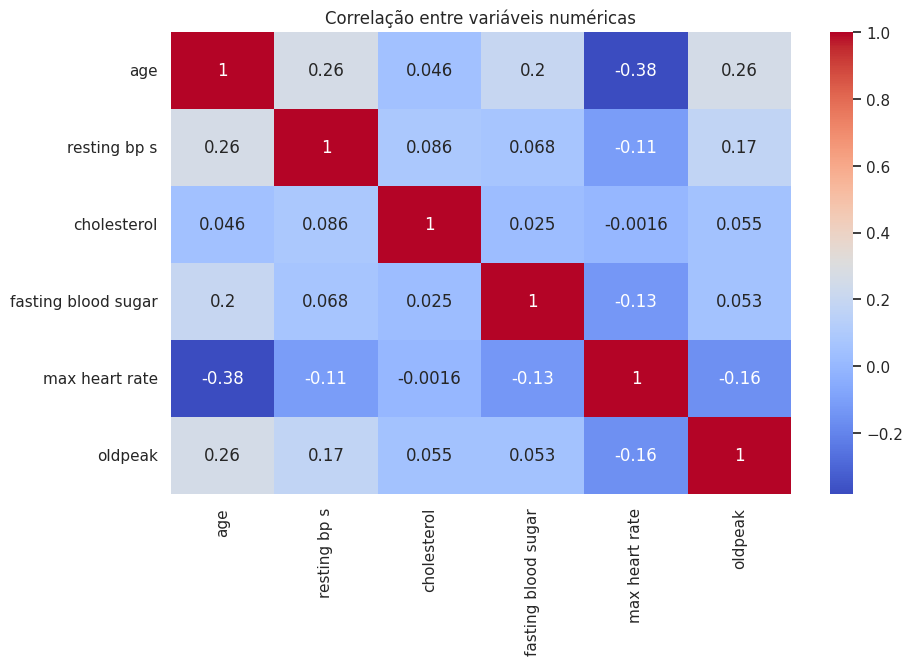

In [47]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_final[numerical_cols].corr(), cmap="coolwarm", annot=True)
plt.title("Correlação entre variáveis numéricas")
plt.show()

### As features mais correlacionadas com o target

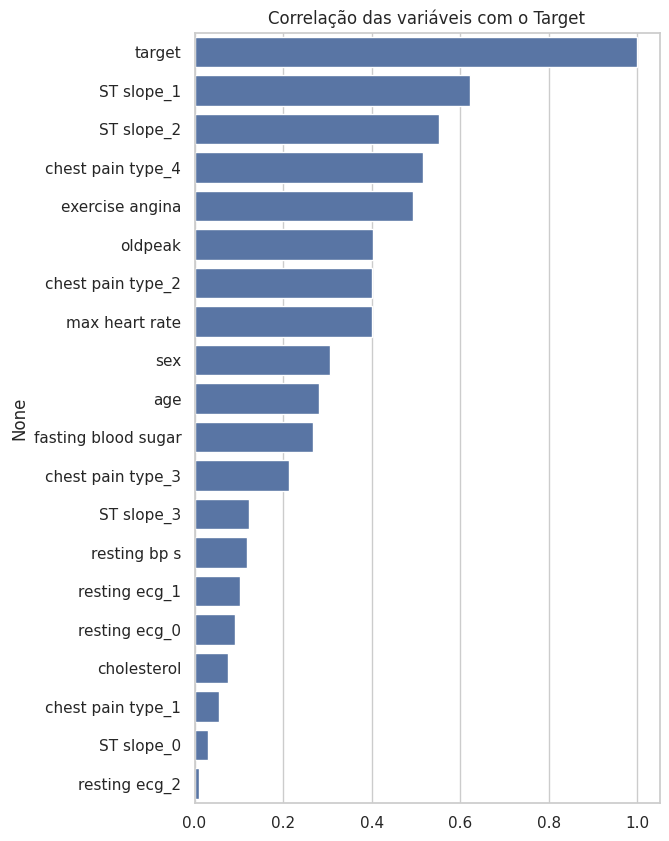

In [53]:
corr = df_final.corr()["target"].abs().sort_values(ascending=False)
plt.figure(figsize=(6, 10))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlação das variáveis com o Target")
plt.show()

## Pairplot

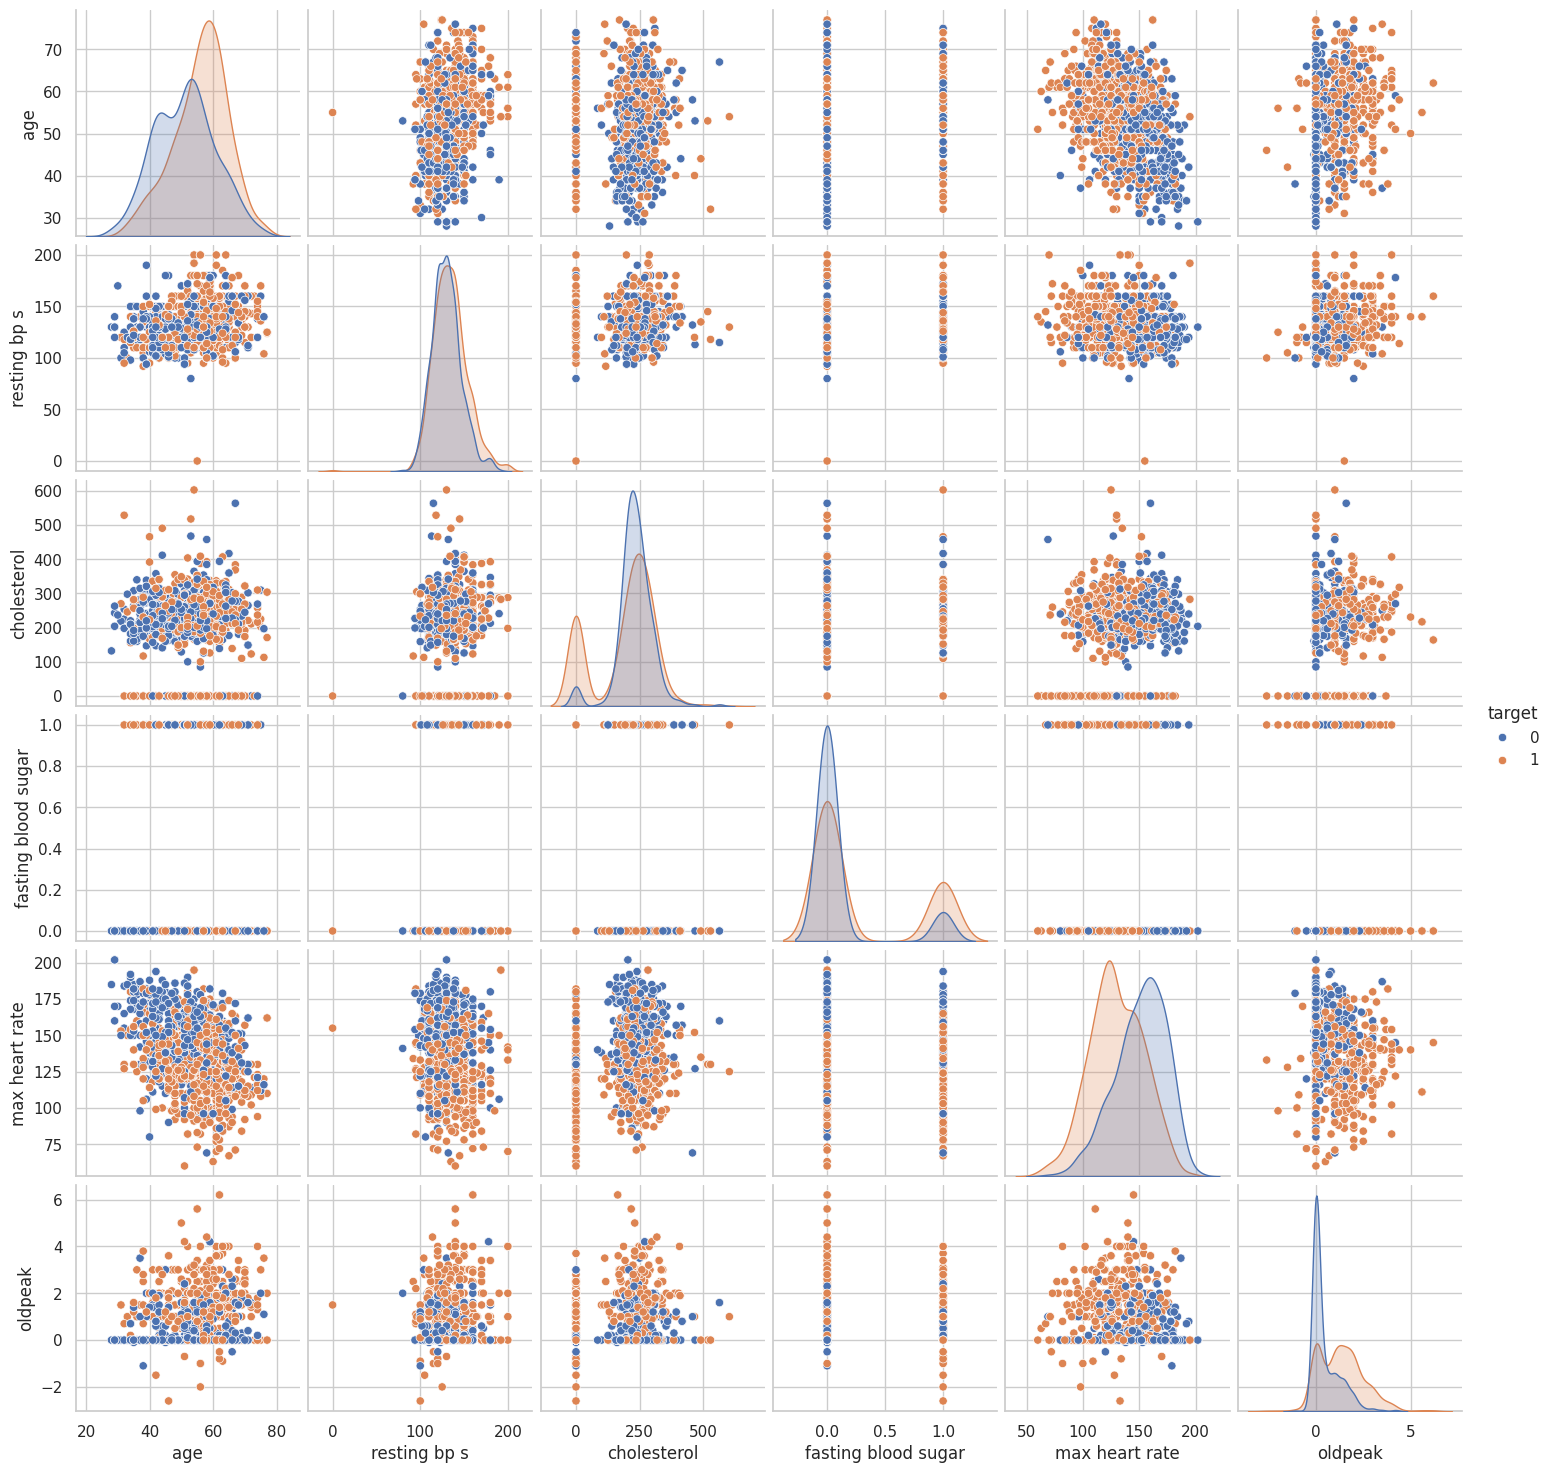

In [48]:
sns.pairplot(df[numerical_cols + ["target"]], hue="target")
plt.show()

## Boxplots

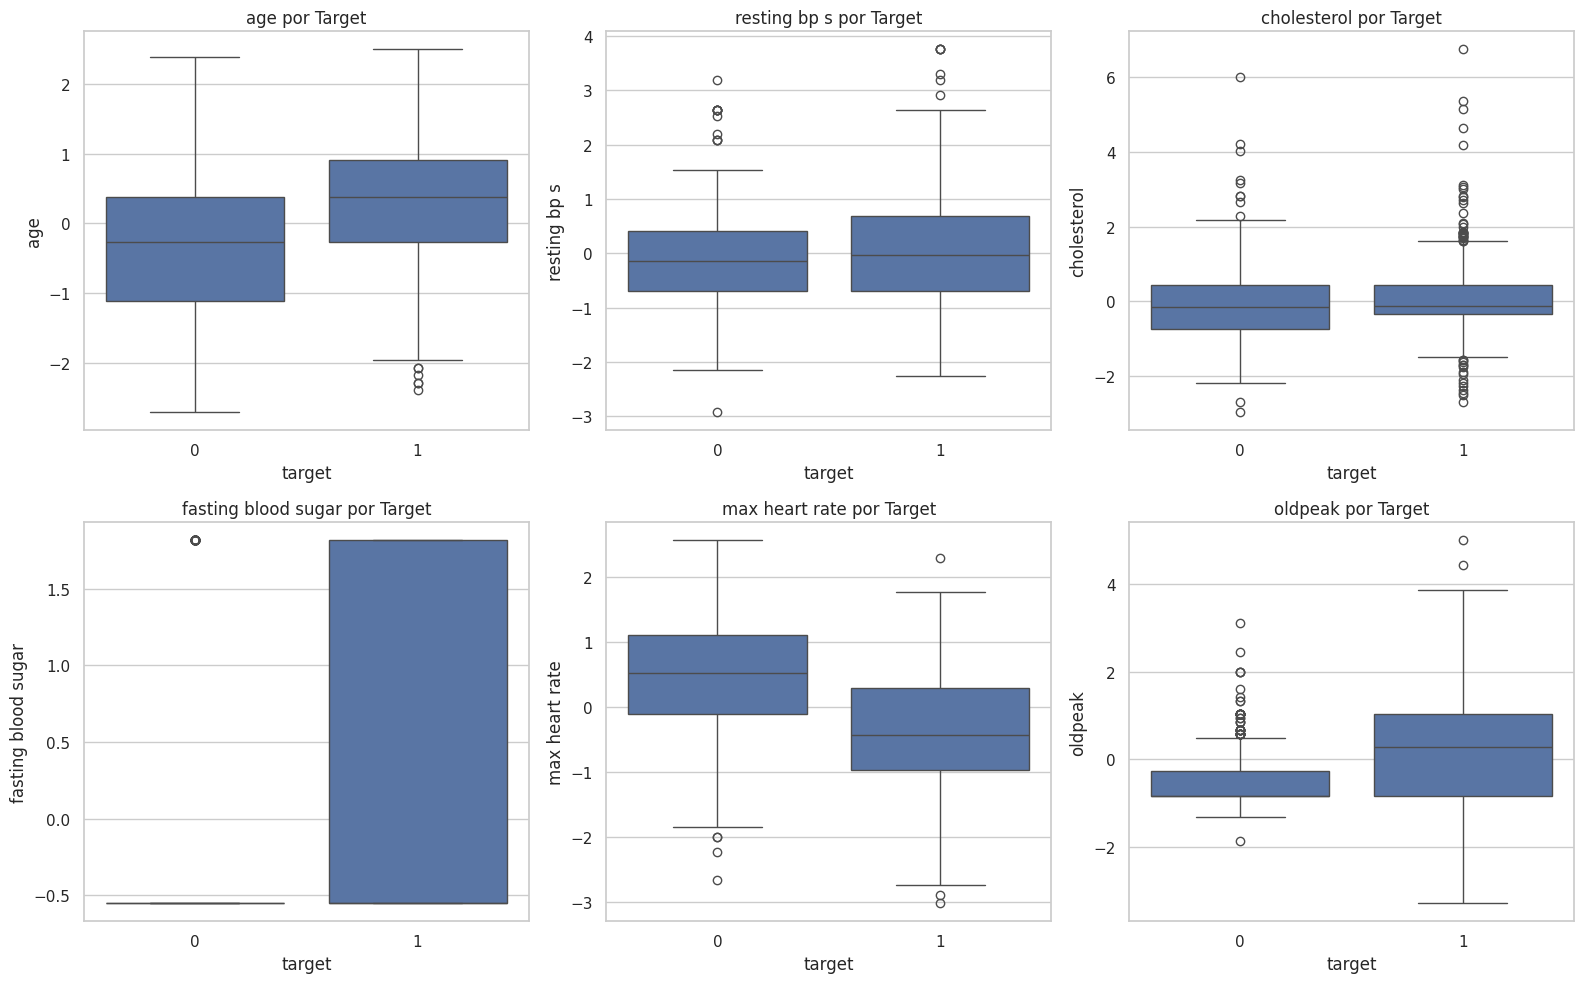

In [51]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="target", y=col, data=df_final)
    plt.title(f"{col} por Target")
plt.tight_layout()
plt.show()

## Violin plots

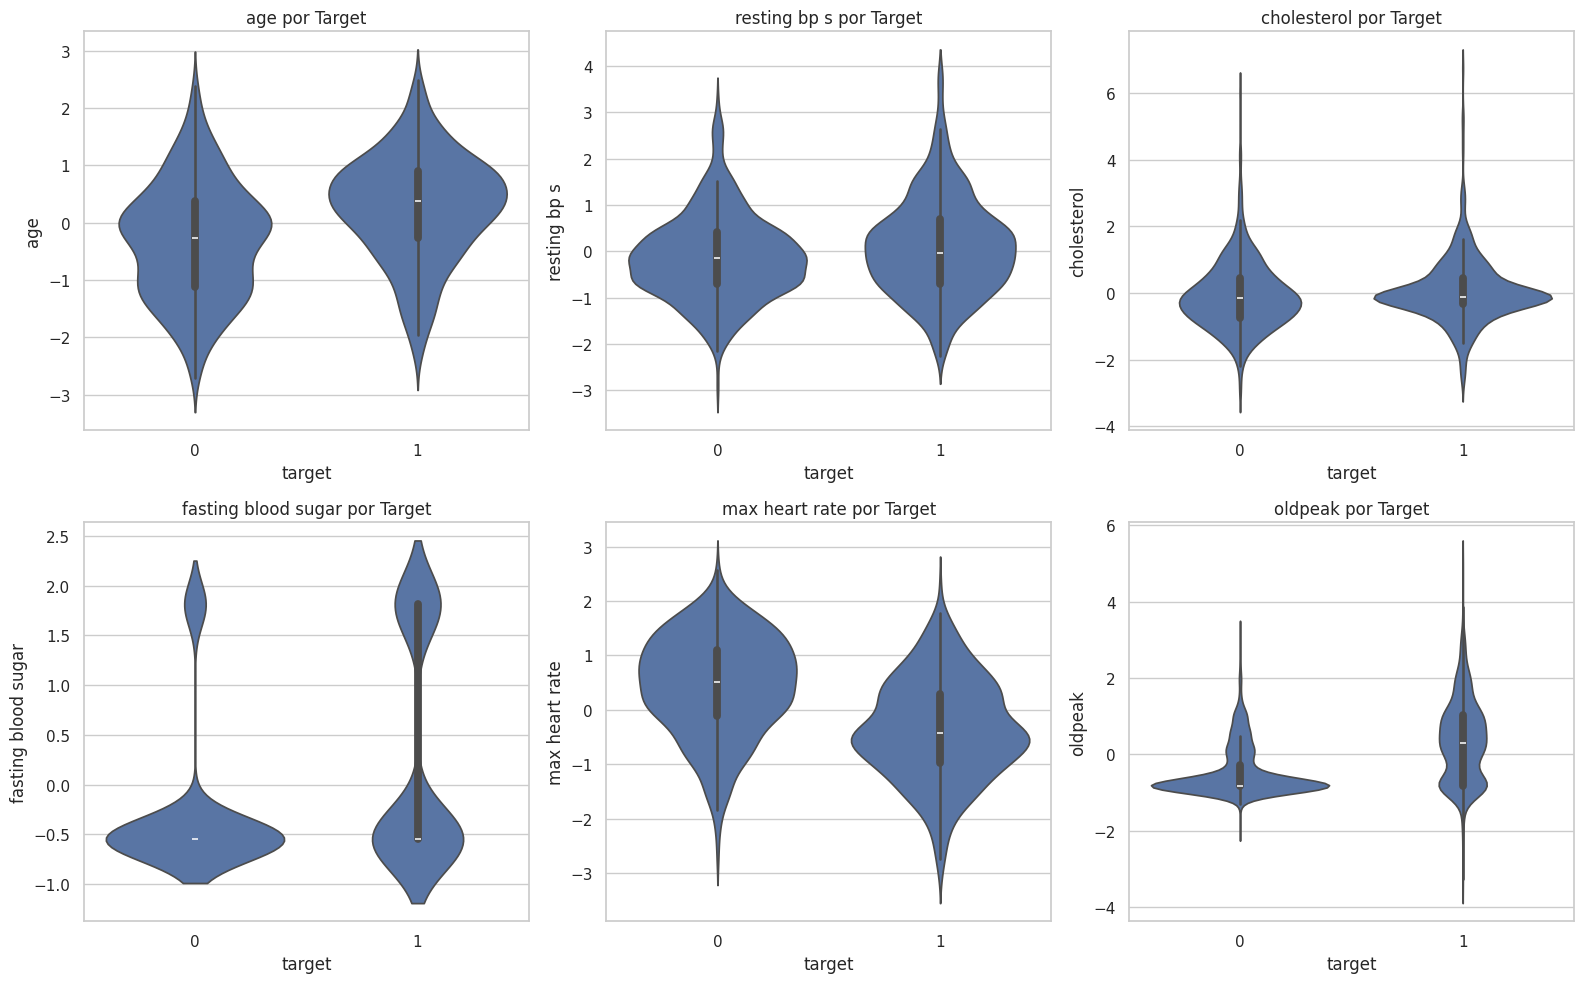

In [52]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x="target", y=col, data=df_final)
    plt.title(f"{col} por Target")
plt.tight_layout()
plt.show()

## Gráfico de Densidade

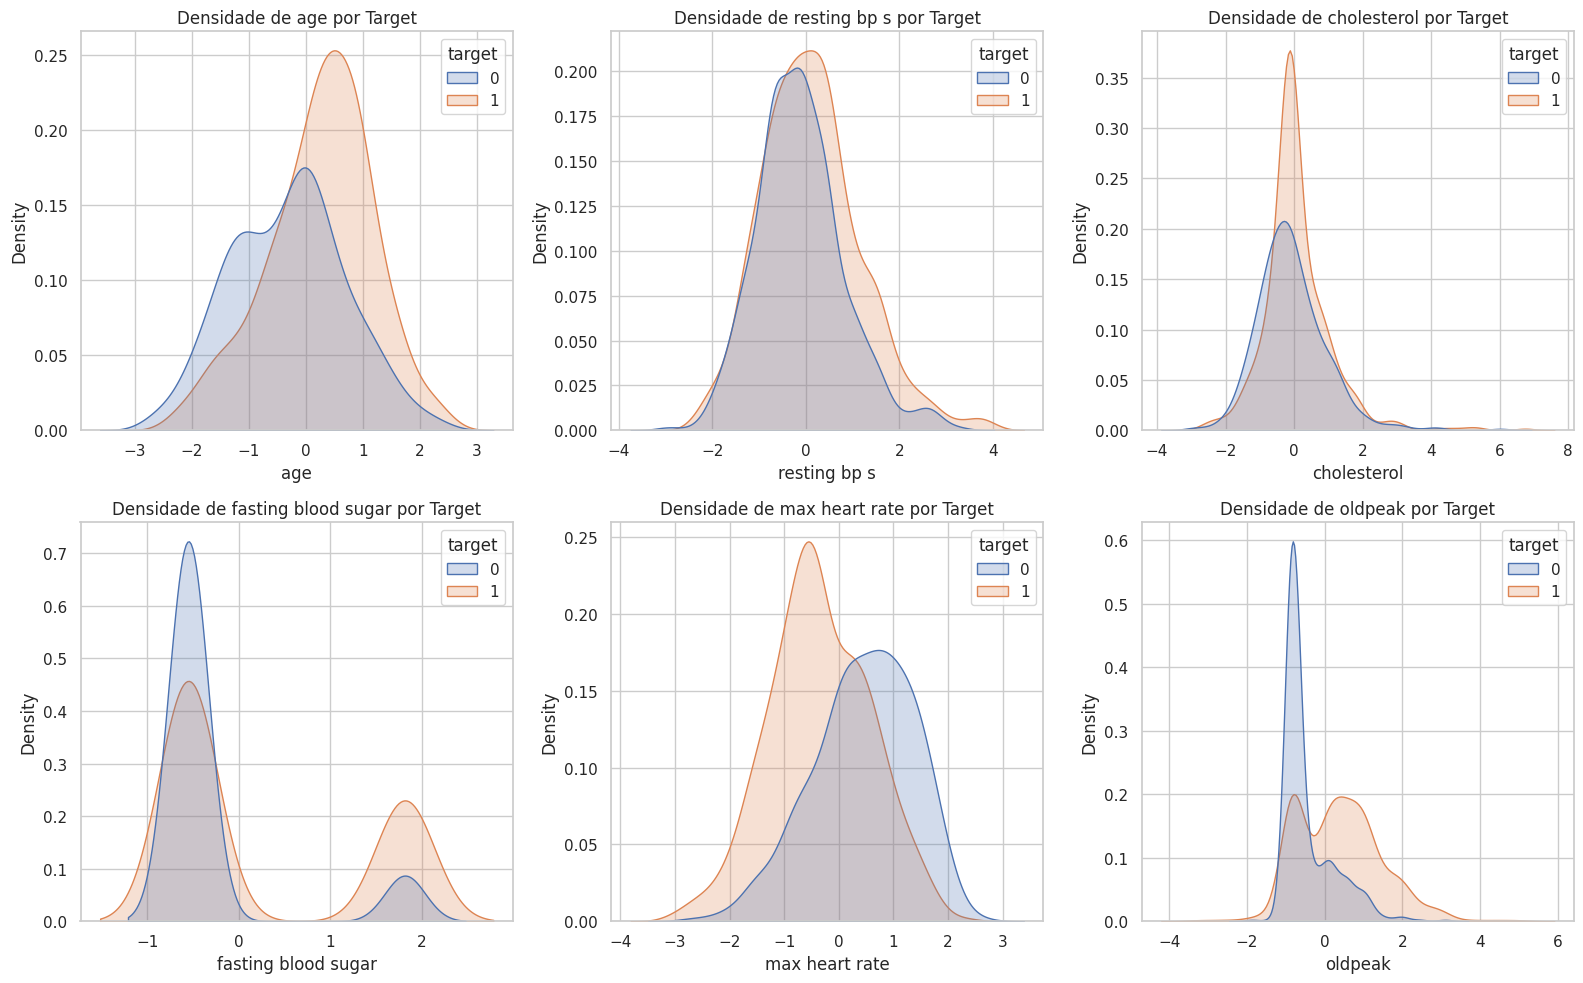

In [54]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=df_final, x=col, hue="target", fill=True)
    plt.title(f"Densidade de {col} por Target")
plt.tight_layout()
plt.show()

# Carregamento dos Dados Pós-processados

In [55]:
df_final = df_scaled.copy()

In [ ]:
# --- 2. CARREGAMENTO NO POSTGRESQL (Estruturação) ---

print("\n--- CARREGANDO DADOS ESTRUTURADOS NO POSTGRESQL ---")

# CÉLULA 3: CONEXÃO E CARREGAMENTO NO POSTGRESQL (LOAD)

# Variáveis de Conexão com PostgreSQL
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_DB = os.environ.get("POSTGRES_DB")
DB_HOST = os.environ.get("DB_HOST") 

DATABASE_URL = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{DB_HOST}:5432/{POSTGRES_DB}"
TABLE_NAME = "clean_heart_data"

try:
    # Este comando REQUIERE que 'create_engine' tenha sido importado!
    engine = create_engine(DATABASE_URL)
    
    # Carregar o DataFrame escalado (
    df_final.to_sql(
        TABLE_NAME, 
        engine, 
        if_exists='replace',
        index=False 
    )
    
    print(f"\nDados finais carregados no PostgreSQL na tabela: {TABLE_NAME}")

except Exception as e:
    # Se der erro aqui, é problema de rede/conexão, não de importação.
    print(f"ERRO CRÍTICO no PostgreSQL: {e}")


--- CARREGANDO DADOS ESTRUTURADOS NO POSTGRESQL ---

Dados finais carregados no PostgreSQL na tabela: clean_heart_data


In [ ]:
# CÉLULA: VERIFICAÇÃO DE CARREGAMENTO NO POSTGRESQL

# 1. Configurar a conexão
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_DB = os.environ.get("POSTGRES_DB")
DB_HOST = os.environ.get("DB_HOST") 
TABLE_NAME = "clean_heart_data" # Nome da tabela salva

DATABASE_URL = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{DB_HOST}:5432/{POSTGRES_DB}"
engine = create_engine(DATABASE_URL)

try:
    # 2. Consultar o número total de linhas na tabela
    count_query = text(f"SELECT COUNT(*) FROM {TABLE_NAME}")
    total_rows = pd.read_sql(count_query, engine).iloc[0, 0]

    # 3. Consultar as 5 primeiras linhas (para inspecionar a escala e a codificação)
    check_query = text(f"SELECT * FROM {TABLE_NAME} LIMIT 5")
    df_check = pd.read_sql(check_query, engine)

    print(f"VERIFICAÇÃO CONCLUÍDA:")
    print(f"Total de linhas salvas na tabela '{TABLE_NAME}': {total_rows}")
    print("\nPrimeiras 5 linhas (devem estar escalonadas/codificadas):")
    print(df_check.head())

except Exception as e:
    print(f"ERRO AO LER DO POSTGRESQL: {e}")

VERIFICAÇÃO CONCLUÍDA:
Total de linhas salvas na tabela 'clean_heart_data': 908

Primeiras 5 linhas (devem estar escalonadas/codificadas):
        age       sex  chest pain type  resting bp s  cholesterol  \
0 -1.436363  0.516128        -1.339139      0.409594     1.052344   
1 -0.481359 -1.937505        -0.266883      1.518455    -1.265402   
2 -1.754698  0.516128        -1.339139     -0.144836     0.924761   
3 -0.587470 -1.937505         0.805373      0.298708    -0.542436   
4  0.049199  0.516128        -0.266883      0.964025    -0.946447   

   fasting blood sugar  resting ecg  max heart rate  exercise angina  \
0            -0.550205    -0.753901        1.380468        -0.827406   
1            -0.550205    -0.753901        0.751928        -0.827406   
2            -0.550205     0.486212       -1.526527        -0.827406   
3            -0.550205    -0.753901       -1.133690         1.208596   
4            -0.550205    -0.753901       -0.583718        -0.827406   

    oldpeak  